#  ARIMA
####  ARIMA를 이용하여 주별 한우 평균경매 금액 예측
---

### 환경설정

In [1]:
import pandas as pd
import os
import numpy as np

import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

import seaborn as sns
import warnings

from matplotlib import font_manager, rc
font_name = font_manager.FontProperties(fname="c:/Windows/Fonts/malgun.ttf").get_name()
rc('font', family=font_name)

import statsmodels.api as sm
import pmdarima as pm
from statsmodels.tsa.stattools import adfuller


from statsmodels.tsa.seasonal import seasonal_decompose

from statsmodels.tsa.api import ExponentialSmoothing
from sklearn.metrics import mean_squared_error


In [2]:
os.chdir(r'C:\Users\a0105\Desktop\DSC\ddd\preprocessing')

### 데이터 불러오기 

In [3]:
data = pd.read_pickle('전체 data.pkl')

In [4]:
data.head(6)

,주간날짜,미국소_생산량(가격화한값),"번식우 아닌 소 중 1세 미만(암,수) 제외",1~2세(모든 소),한우 평균경매 금액_주간평균,돼지 탕박 경매 금액_주간평균,수출 (100만달러),수입 (100만달러),소비자물가지수 (2010=100),수입소고기_총량,평균기온,최저기온,최고기온,평균지면온도,최소상대습도(%),평균상대습도(%)
0,2013-01-06,226130.0,520,888,13875.60,3044.80,559632,515586,98,28623,-0.3,-4.6,5.4,-2.5,16.0,29.6
1,2013-01-13,226130.0,520,888,13213.33,2984.00,559632,515586,98,28623,1.4,-2.2,6.1,0.0,30.0,49.6
2,2013-01-20,226130.0,520,888,12588.83,2904.00,559632,515586,98,28623,1.5,-2.2,2.7,0.1,40.0,64.9
3,2013-01-27,226130.0,520,888,12323.83,2959.67,559632,515586,98,28623,3.8,-0.9,9.3,0.4,40.0,63.0
4,2013-02-03,187340.0,520,888,12325.17,2862.83,559632,515586,98,18241,1.5,-1.9,4.5,0.8,22.0,48.4
5,2013-02-10,187340.0,520,888,12510.25,2109.00,559632,515586,98,18241,0.5,-3.8,4.9,0.4,21.0,37.3


In [5]:
df = data[['주간날짜','한우 평균경매 금액_주간평균']].set_index('주간날짜')

### 데이터 탐색

In [6]:
def check_stationarity(y, lags_plots=48, figsize=(16,8)):
    "Use Series as parameter"
    
    # Creating plots of the DF
    y = pd.Series(y)
    fig = plt.figure()

    ax1 = plt.subplot2grid((3, 3), (0, 0), colspan=2)
    ax2 = plt.subplot2grid((3, 3), (1, 0))
    ax3 = plt.subplot2grid((3, 3), (1, 1))
    ax4 = plt.subplot2grid((3, 3), (2, 0), colspan=2)

    y.plot(ax=ax1, figsize=figsize)
    ax1.set_title('한우 평균경매 금액_주간평균')
    plot_acf(y, lags=lags_plots, zero=False, ax=ax2);
    plot_pacf(y, lags=lags_plots, zero=False, ax=ax3);
    sns.distplot(y, bins=int(np.sqrt(len(y))), ax=ax4)
    ax4.set_title('Distribution Chart')

    plt.tight_layout()
    
    print('Results of Dickey-Fuller Test:')
    adfinput = adfuller(y)
    adftest = pd.Series(adfinput[0:4], index=['Test Statistic','p-value','Lags Used','Number of Observations Used'])
    adftest = round(adftest,4)
    
    for key, value in adfinput[4].items():
        adftest["Critical Value (%s)"%key] = value.round(4)
        
    print(adftest)
    
    if adftest[0].round(2) < adftest[5].round(2):
        print('\nThe Test Statistics is lower than the Critical Value of 5%.\nThe serie seems to be stationary')
    else:
        print("\nThe Test Statistics is higher than the Critical Value of 5%.\nThe serie isn't stationary")

Results of Dickey-Fuller Test:
Test Statistic                  -1.4781
p-value                          0.5443
Lags Used                        7.0000
Number of Observations Used    290.0000
Critical Value (1%)             -3.4531
Critical Value (5%)             -2.8716
Critical Value (10%)            -2.5721
dtype: float64

The Test Statistics is higher than the Critical Value of 5%.
The serie isn't stationary


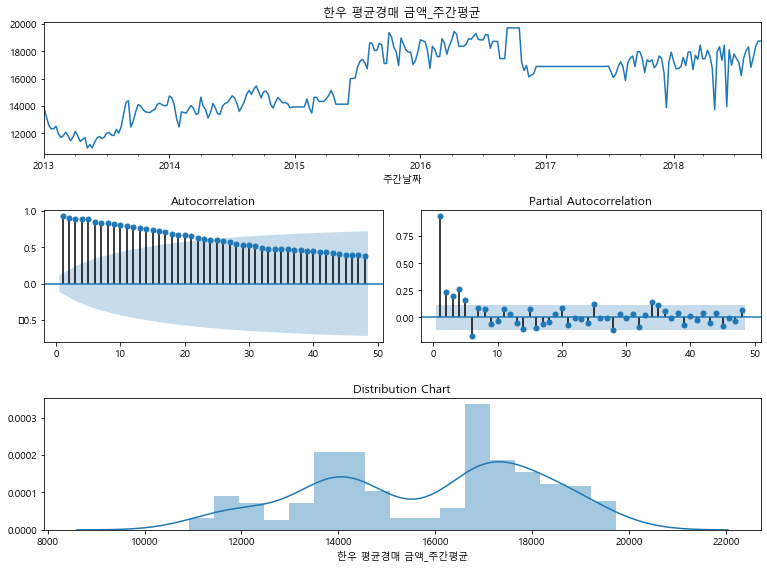

In [7]:
warnings.filterwarnings(action='ignore')

check_stationarity(df['한우 평균경매 금액_주간평균'])

* 추세 존재

Results of Dickey-Fuller Test:
Test Statistic                  -8.8557
p-value                          0.0000
Lags Used                        6.0000
Number of Observations Used    290.0000
Critical Value (1%)             -3.4531
Critical Value (5%)             -2.8716
Critical Value (10%)            -2.5721
dtype: float64

The Test Statistics is lower than the Critical Value of 5%.
The serie seems to be stationary


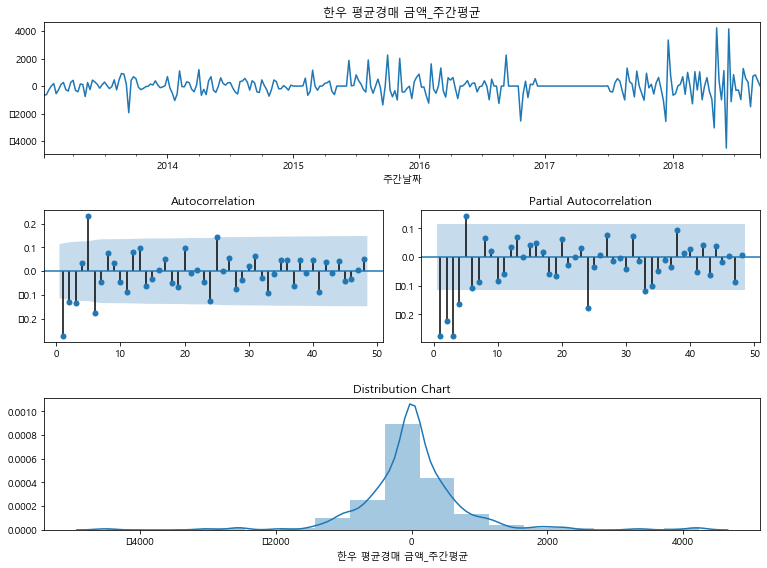

In [8]:
warnings.filterwarnings(action='ignore')

# 차분 
check_stationarity(df['한우 평균경매 금액_주간평균'].diff().dropna())

* 차분을 한 번 한 후 AR(3), MA(1)또는 MA(2), MA(3) 추정

### 분해법

In [10]:
'''result = seasonal_decompose(df, model='additive')

plt.rcParams['figure.figsize'] = [12, 8]

result.plot()

plt.show()'''

"result = seasonal_decompose(df, model='additive')\n\nplt.rcParams['figure.figsize'] = [12, 8]\n\nresult.plot()\n\nplt.show()"

### 홀트윕터스 가법, 승법 주별 예측하여 rmse비교 

In [11]:
'''fit1 = ExponentialSmoothing(np.asarray(train) ,seasonal_periods=7 ,trend='add', seasonal='add',).fit()
fit1.forecast(len(test))

rms = np.sqrt(mean_squared_error(test['한우 평균경매 금액_주간평균'], fit1.forecast(len(test))))
print(rms)

fit1 = ExponentialSmoothing(np.asarray(train) ,seasonal_periods=7 ,trend='add', seasonal='mul',).fit()

rms = np.sqrt(mean_squared_error(test['한우 평균경매 금액_주간평균'], fit1.forecast(len(test))))
print(rms)'''

"fit1 = ExponentialSmoothing(np.asarray(train) ,seasonal_periods=7 ,trend='add', seasonal='add',).fit()\nfit1.forecast(len(test))\n\nrms = np.sqrt(mean_squared_error(test['한우 평균경매 금액_주간평균'], fit1.forecast(len(test))))\nprint(rms)\n\nfit1 = ExponentialSmoothing(np.asarray(train) ,seasonal_periods=7 ,trend='add', seasonal='mul',).fit()\n\nrms = np.sqrt(mean_squared_error(test['한우 평균경매 금액_주간평균'], fit1.forecast(len(test))))\nprint(rms)"

* 승법모형: 계절변동이 규칙적이면서 주기의 폭이 커지거나 작아지는 경우 적합한 모형
* 가법모형: 계절변동이 상수이면서 시간에 의존하지 않고 주기의 폭이 일정한 경우 사용 

### auto.arima

In [14]:
split_date = '2018-02-07'

train = df[df.index <= split_date].copy()
test = df[df.index > split_date].copy()

model = pm.auto_arima(train['한우 평균경매 금액_주간평균'], seasonal=True, m=7)
print(model.aic())

model.fit(train['한우 평균경매 금액_주간평균'])


4127.548147009424


ARIMA(maxiter=50, method='lbfgs', order=(2, 1, 1), out_of_sample_size=0,
      scoring='mse', scoring_args=None, seasonal_order=(1, 0, 2, 7),
      start_params=None, suppress_warnings=False, trend=None,
      with_intercept=True)

In [15]:
test.shape

(32, 1)

[17038.11142798 16965.19211807 17164.90788796 17310.20277484
 17164.36684001 17270.20511944 17482.4735229  17472.06094012
 17351.75982095 17254.37341376 17242.65408164 17461.12995394
 17394.46752651 17164.36782623 17211.70149483 17375.06771817
 17503.91332005 17546.65431124 17384.3074663  17478.85447566
 17720.03120942 17713.41781757 17602.96600441 17523.26896387
 17520.44434666 17700.56133162 17651.56371749 17471.78420783
 17512.98998537 17646.8048073  17753.19295178 17791.02354945]


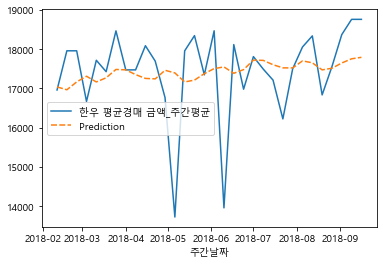

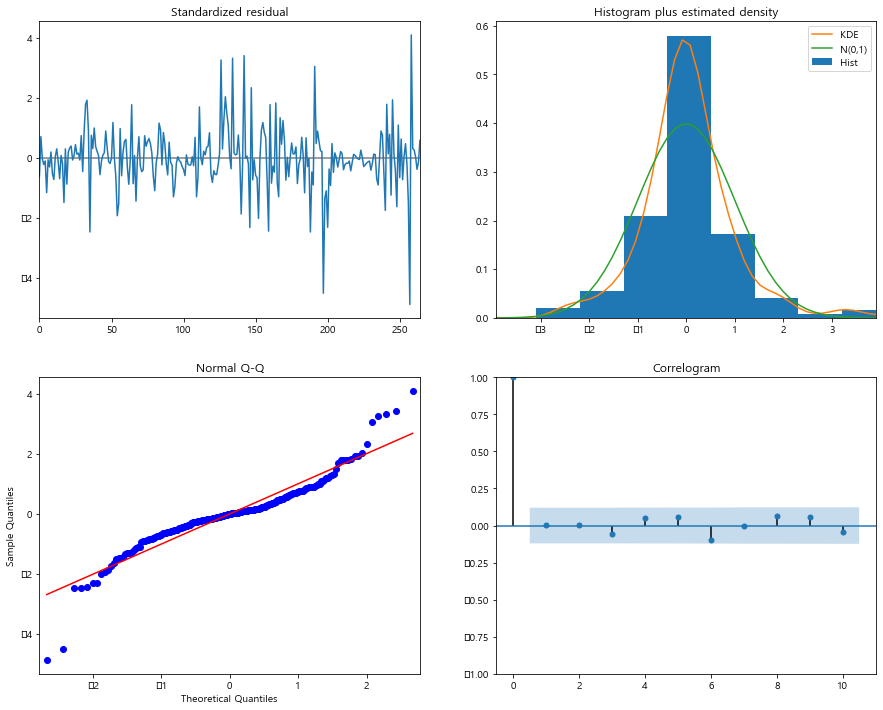

In [16]:
future_forecast = model.predict(n_periods=32)

print(future_forecast)

future_forecast = pd.DataFrame(future_forecast,index = test.index,columns=['Prediction'])
future_data = pd.concat([test,future_forecast],axis=1)

sns.lineplot(data = future_data)

model.plot_diagnostics(figsize=(15, 12))
plt.show()

제대로 예측하지 못함.

* KDE선은 정규분포와 밀접한 관계가 있는 것으로 잔차가 정규적으로 분포되어 있음을 보여줌
* qqplot 또한 어느 정도 정규분포를 따르고 있다고 말할 수 있음.
* 잔차는 뚜렷한 계절성을 나타내지 않고 백색 잡음으로 보임. 이는 잔차끼리 상관 관계가 낮다는 것을 의미

### grid search

In [127]:
'''import itertools

d = range(1,2)
p = q = range(0, 3)

# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, q and q triplets
seasonal_pdq = [(x[0], x[1], x[2], 7) for x in list(itertools.product(p, d, q))]

print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

split_date = '2018-01-07'

train = df[df.index <= split_date].copy()
test = df[df.index > split_date].copy()

# 0, 1, 2 |2 , 1, 2, 12
import warnings

warnings.filterwarnings("ignore") # specify to ignore warning messages

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(train['한우 평균경매 금액_주간평균'],
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            results = mod.fit()

            print('ARIMA{}x{}7 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue
            
mod = sm.tsa.statespace.SARIMAX(train['한우 평균경매 금액_주간평균'],
                                order=(2, 1, 2),
                                seasonal_order=(2, 1, 2, 7),
                                enforce_stationarity=False,
                                enforce_invertibility=False)

results = mod.fit()

print(results.summary().tables[1])

results.plot_diagnostics(figsize=(15, 12))
plt.show()

mod = sm.tsa.statespace.SARIMAX(train['한우 평균경매 금액_주간평균'],
                                order=(3, 1, 2),
                                seasonal_order=(1, 1, 2, 7),
                                enforce_stationarity=False,
                                enforce_invertibility=False)

results = mod.fit()

print(results.summary().tables[1])

results.plot_diagnostics(figsize=(15, 12))
plt.show()

# Forecast
fc, se, conf = mod.forecast(36, alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=test.index)
lower_series = pd.Series(conf[:, 0], index=test.index)
upper_series = pd.Series(conf[:, 1], index=test.index)

# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train, label='training')
plt.plot(test, label='actual')
plt.plot(fc_series, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show() '''

'import itertools\n\nd = range(1,2)\np = q = range(0, 3)\n\n# Generate all different combinations of p, q and q triplets\npdq = list(itertools.product(p, d, q))\n\n# Generate all different combinations of seasonal p, q and q triplets\nseasonal_pdq = [(x[0], x[1], x[2], 7) for x in list(itertools.product(p, d, q))]\n\nprint(\'Examples of parameter combinations for Seasonal ARIMA...\')\nprint(\'SARIMAX: {} x {}\'.format(pdq[1], seasonal_pdq[1]))\nprint(\'SARIMAX: {} x {}\'.format(pdq[1], seasonal_pdq[2]))\nprint(\'SARIMAX: {} x {}\'.format(pdq[2], seasonal_pdq[3]))\nprint(\'SARIMAX: {} x {}\'.format(pdq[2], seasonal_pdq[4]))\n\nsplit_date = \'2018-01-07\'\n\ntrain = df[df.index <= split_date].copy()\ntest = df[df.index > split_date].copy()\n\n# 0, 1, 2 |2 , 1, 2, 12\nimport warnings\n\nwarnings.filterwarnings("ignore") # specify to ignore warning messages\n\nfor param in pdq:\n    for param_seasonal in seasonal_pdq:\n        try:\n            mod = sm.tsa.statespace.SARIMAX(train[\'한우 평균